In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from pyepo.model.grb import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 40.024
0 -> 10 -> 15 -> 16 -> 6 -> 18 -> 14 -> 1 -> 4 -> 19 -> 11 -> 13 -> 2 -> 9 -> 12 -> 8 -> 7 -> 5 -> 3 -> 17 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.19it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 108.98it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    # draw plot
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 1e-2
num_epochs = 300
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  65.5070, Regret: 193.2252%
Epoch  20, Loss:  64.3356, Regret: 45.6618%
Epoch  40, Loss:  45.5071, Regret: 30.0846%
Epoch  60, Loss:  27.9555, Regret: 24.7757%
Epoch  80, Loss:  41.6711, Regret: 22.9097%
Epoch 100, Loss:  25.4960, Regret: 21.5469%
Epoch 120, Loss:  10.0996, Regret: 20.3151%
Epoch 140, Loss:   5.0863, Regret: 19.5464%
Epoch 160, Loss:  15.7151, Regret: 18.8071%
Epoch 180, Loss:  10.3082, Regret: 18.4586%
Epoch 200, Loss:  14.8422, Regret: 18.0151%
Epoch 220, Loss:  32.4459, Regret: 17.5821%
Epoch 240, Loss:  15.2440, Regret: 17.3699%
Epoch 260, Loss:  19.6357, Regret: 17.0412%
Epoch 280, Loss:  11.0981, Regret: 16.8405%
Elapsed Time: 5.27 Sec


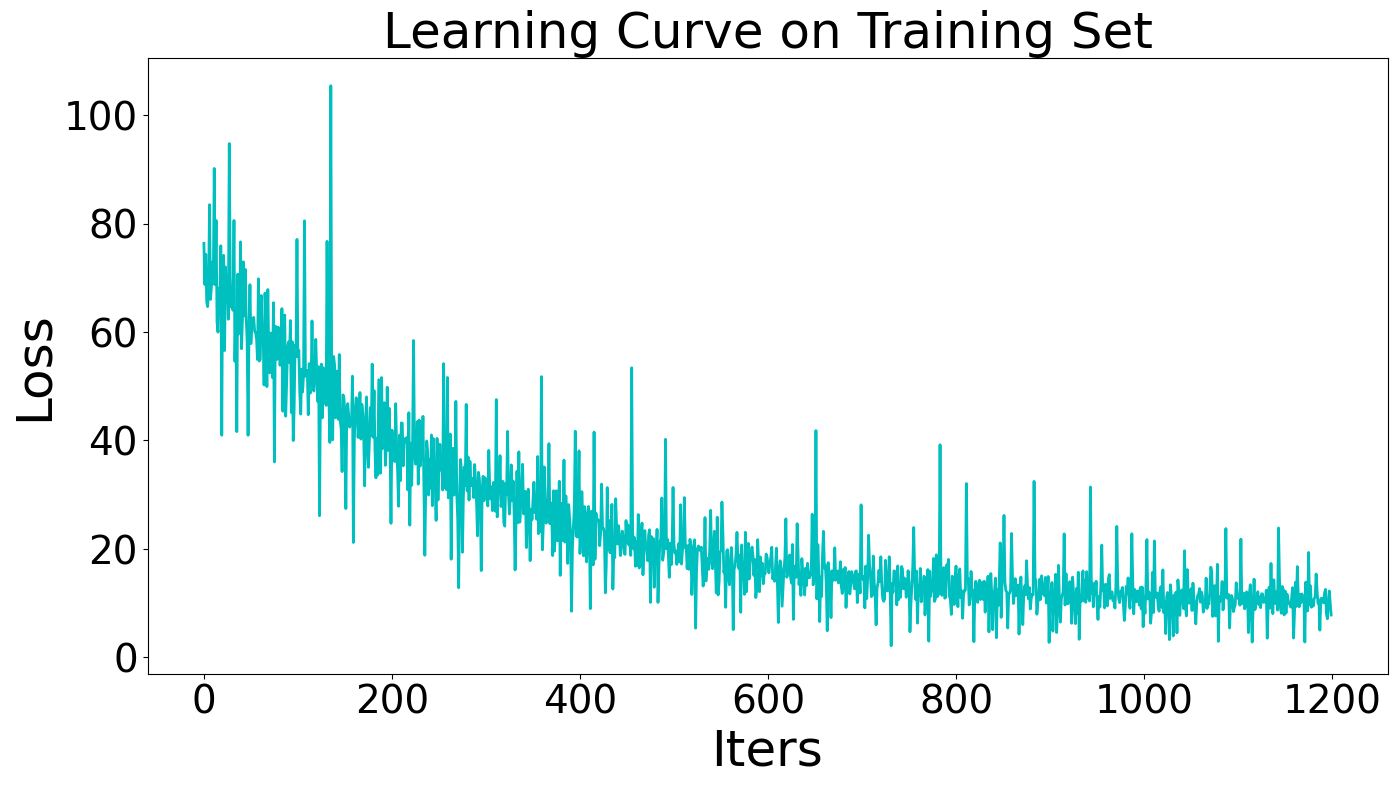

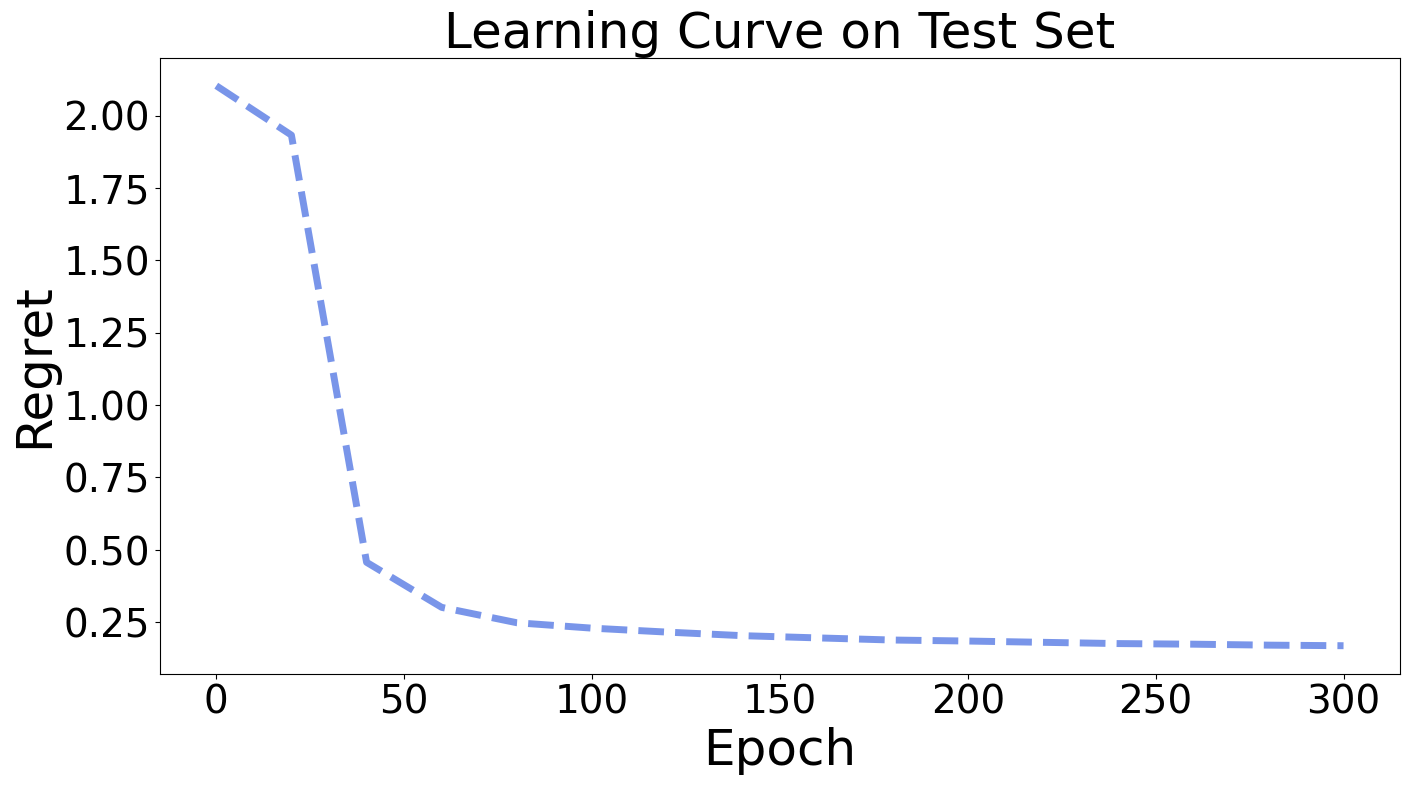

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [17]:
lr = 1e-2
num_epochs = 300
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9252, Regret: 197.7516%
Epoch  20, Loss:  -0.9966, Regret: 45.8651%
Epoch  40, Loss:  -0.9996, Regret: 30.2027%
Epoch  60, Loss:  -0.9997, Regret: 26.1188%
Epoch  80, Loss:  -0.9998, Regret: 24.2997%
Epoch 100, Loss:  -0.9999, Regret: 23.4838%
Epoch 120, Loss:  -0.9999, Regret: 22.2295%
Epoch 140, Loss:  -0.9999, Regret: 21.9087%
Epoch 160, Loss:  -1.0000, Regret: 21.5377%
Epoch 180, Loss:  -1.0000, Regret: 21.2428%
Epoch 200, Loss:  -1.0000, Regret: 21.2336%
Epoch 220, Loss:  -1.0000, Regret: 20.7483%
Epoch 240, Loss:  -0.9999, Regret: 20.6386%
Epoch 260, Loss:  -1.0000, Regret: 20.8927%
Epoch 280, Loss:  -1.0000, Regret: 20.4843%
Elapsed Time: 30169.35 Sec


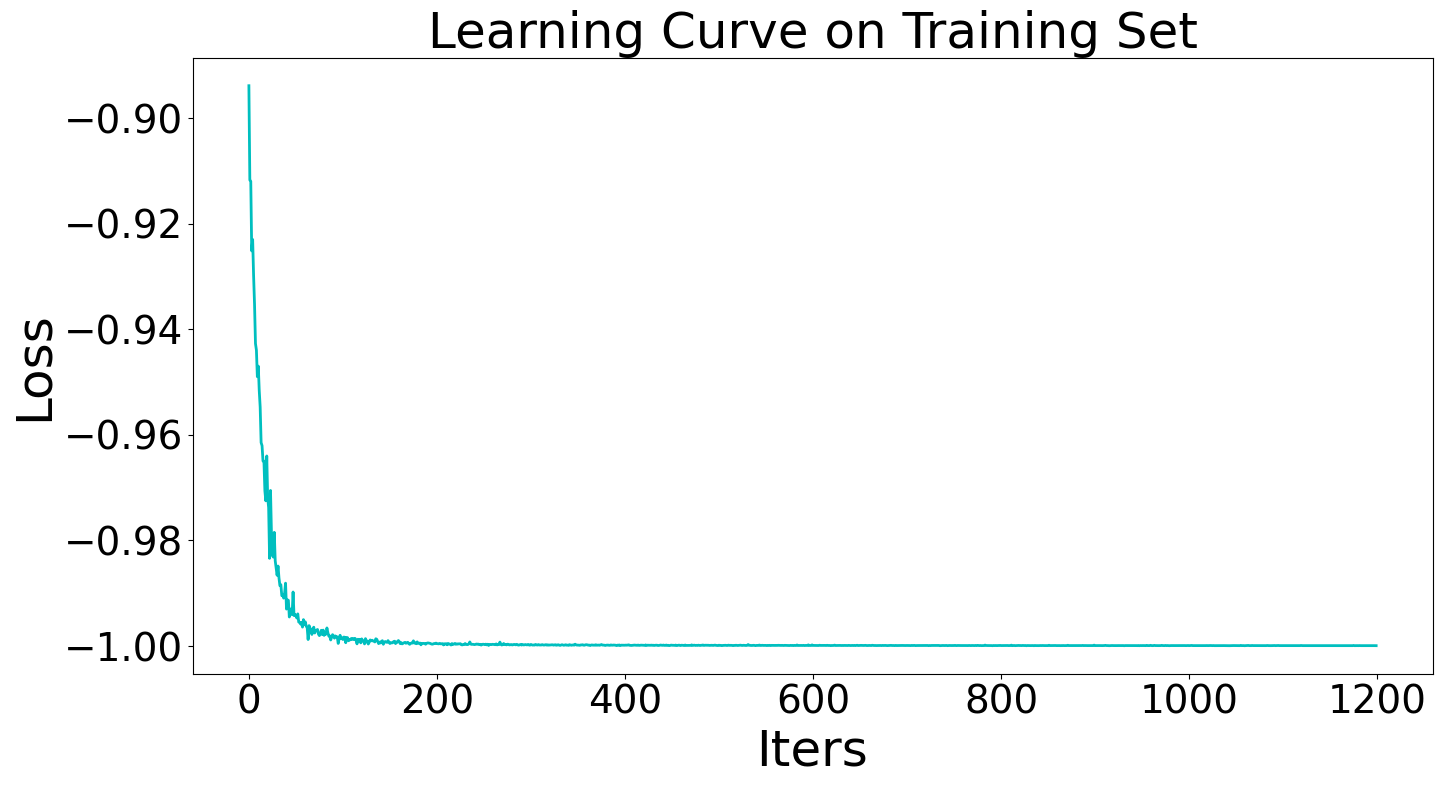

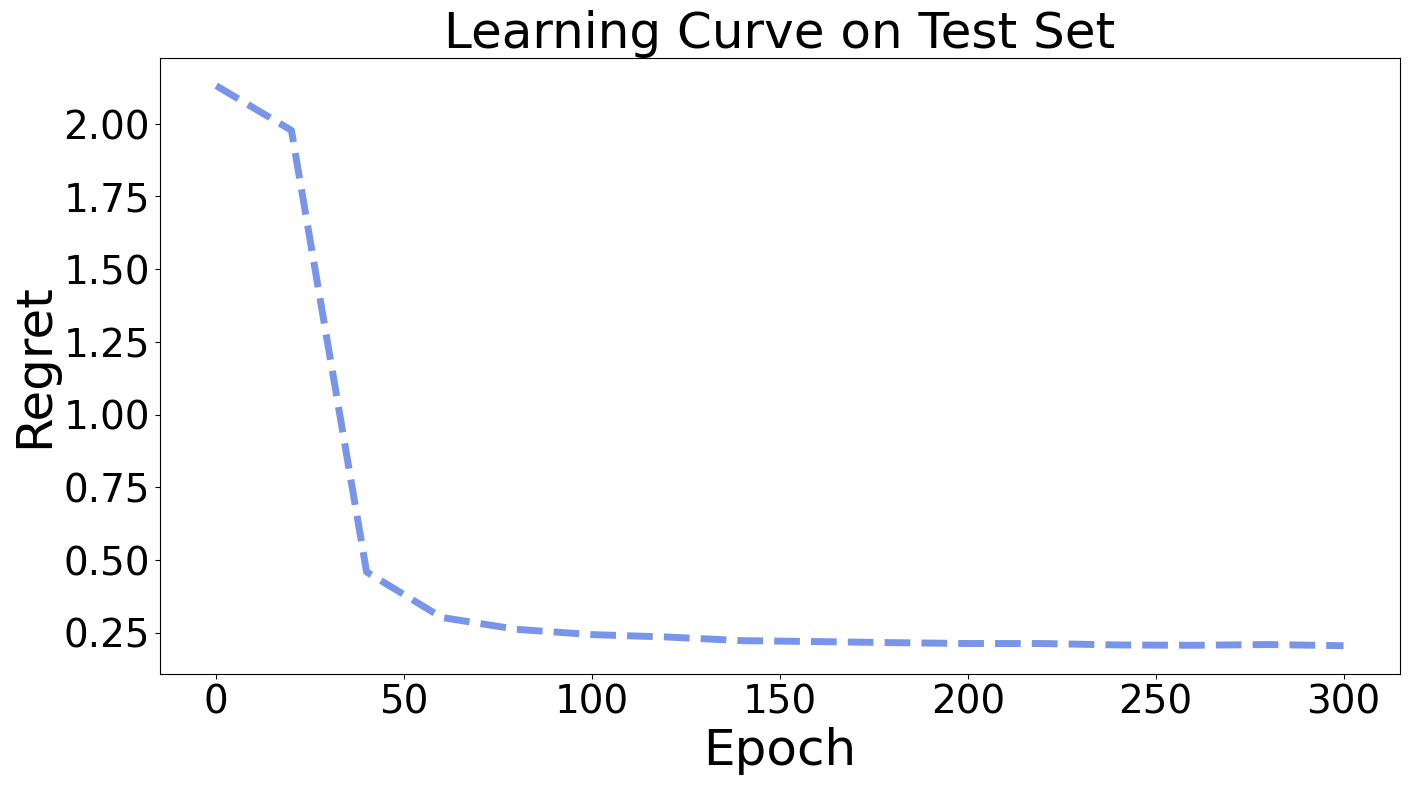

In [18]:
plot(loss_log, regret_log, num_epochs, log_step)

###  Base Vector Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import baseVectConeAlignedCosine
# init loss
ca_cos = baseVectConeAlignedCosine(optmodel)

In [21]:
lr = 1e-2
num_epochs = 300
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.2036, Regret: 231.3332%
Epoch  20, Loss:  -0.8549, Regret: 219.1017%
Epoch  40, Loss:  -0.8613, Regret: 193.4363%
Epoch  60, Loss:  -0.8791, Regret: 220.4284%
Epoch  80, Loss:  -0.9440, Regret: 190.8940%
Epoch 100, Loss:  -0.9812, Regret: 212.9724%
Epoch 120, Loss:  -0.9829, Regret: 212.5371%
Epoch 140, Loss:  -0.9508, Regret: 225.0805%
Epoch 160, Loss:  -0.9757, Regret: 198.7746%
Epoch 180, Loss:  -0.9860, Regret: 199.4429%
Epoch 200, Loss:  -0.9917, Regret: 182.0248%
Epoch 220, Loss:  -0.9358, Regret: 215.5170%
Epoch 240, Loss:  -0.9637, Regret: 187.9198%
Epoch 260, Loss:  -0.9465, Regret: 195.6425%
Epoch 280, Loss:  -0.9699, Regret: 206.3436%
Elapsed Time: 21.13 Sec


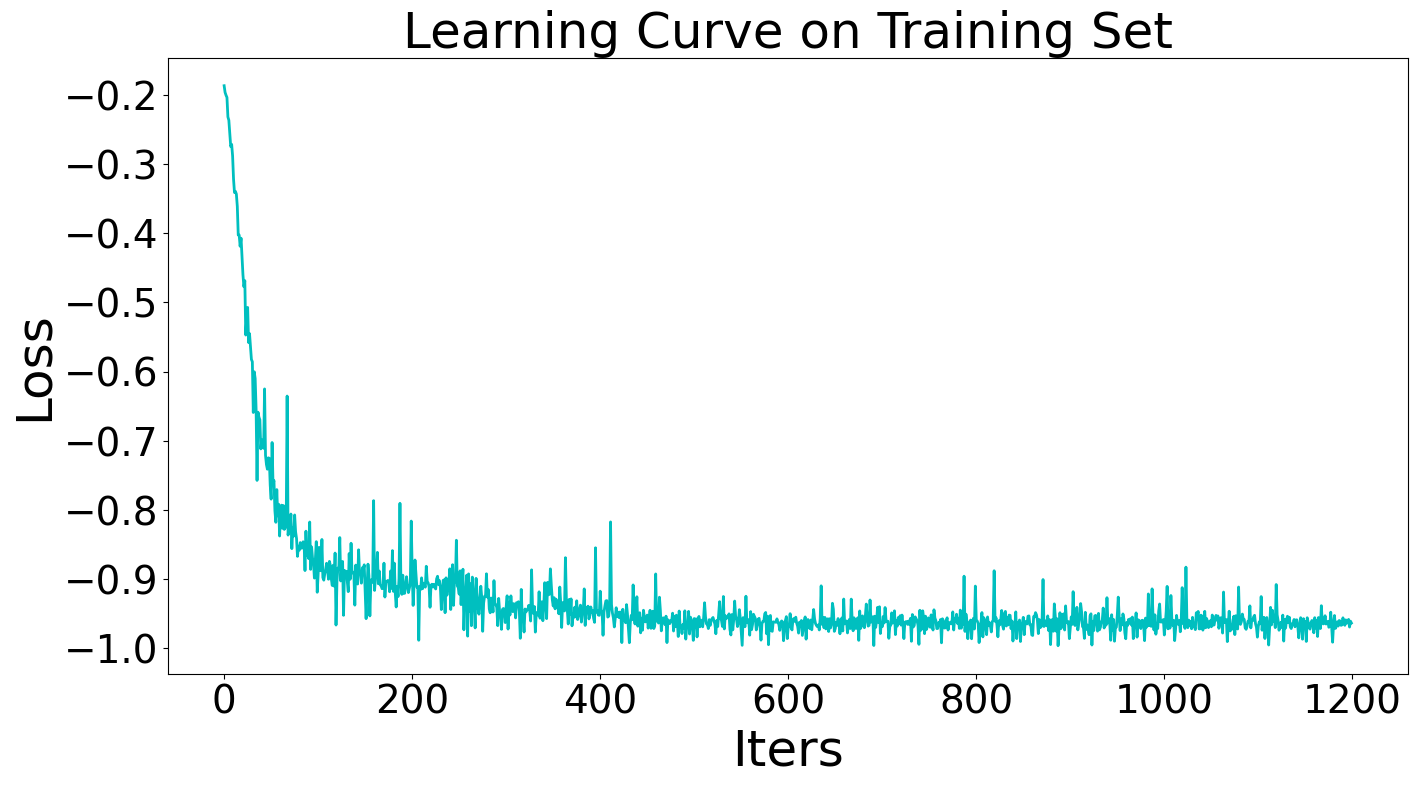

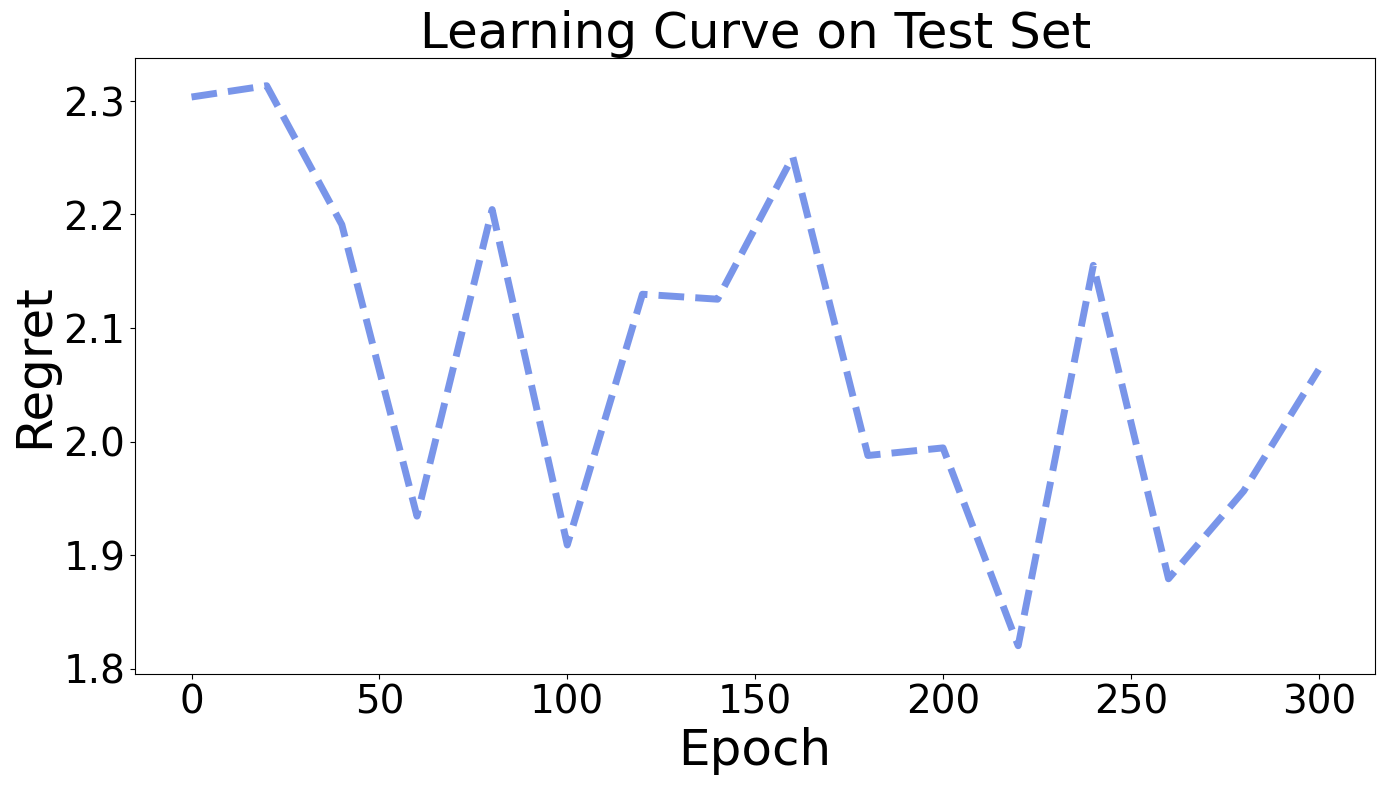

In [22]:
plot(loss_log, regret_log, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 1e-2
num_epochs = 300
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.2314, Regret: 206.6525%
Epoch  20, Loss:  -0.7802, Regret: 36.3226%
Epoch  40, Loss:  -0.8389, Regret: 16.3146%
Epoch  60, Loss:  -0.8378, Regret: 16.0811%
Epoch  80, Loss:  -0.8216, Regret: 16.7579%
Epoch 100, Loss:  -0.8160, Regret: 17.0972%
Epoch 120, Loss:  -0.8276, Regret: 16.9187%
Epoch 140, Loss:  -0.8064, Regret: 17.6064%
Epoch 160, Loss:  -0.8440, Regret: 17.0093%
Epoch 180, Loss:  -0.8066, Regret: 16.4959%
Epoch 200, Loss:  -0.8077, Regret: 16.3014%
Epoch 220, Loss:  -0.8321, Regret: 16.7112%
Epoch 240, Loss:  -0.8226, Regret: 18.3129%
Epoch 260, Loss:  -0.8303, Regret: 17.1365%
Epoch 280, Loss:  -0.8471, Regret: 16.5624%
Elapsed Time: 26.02 Sec


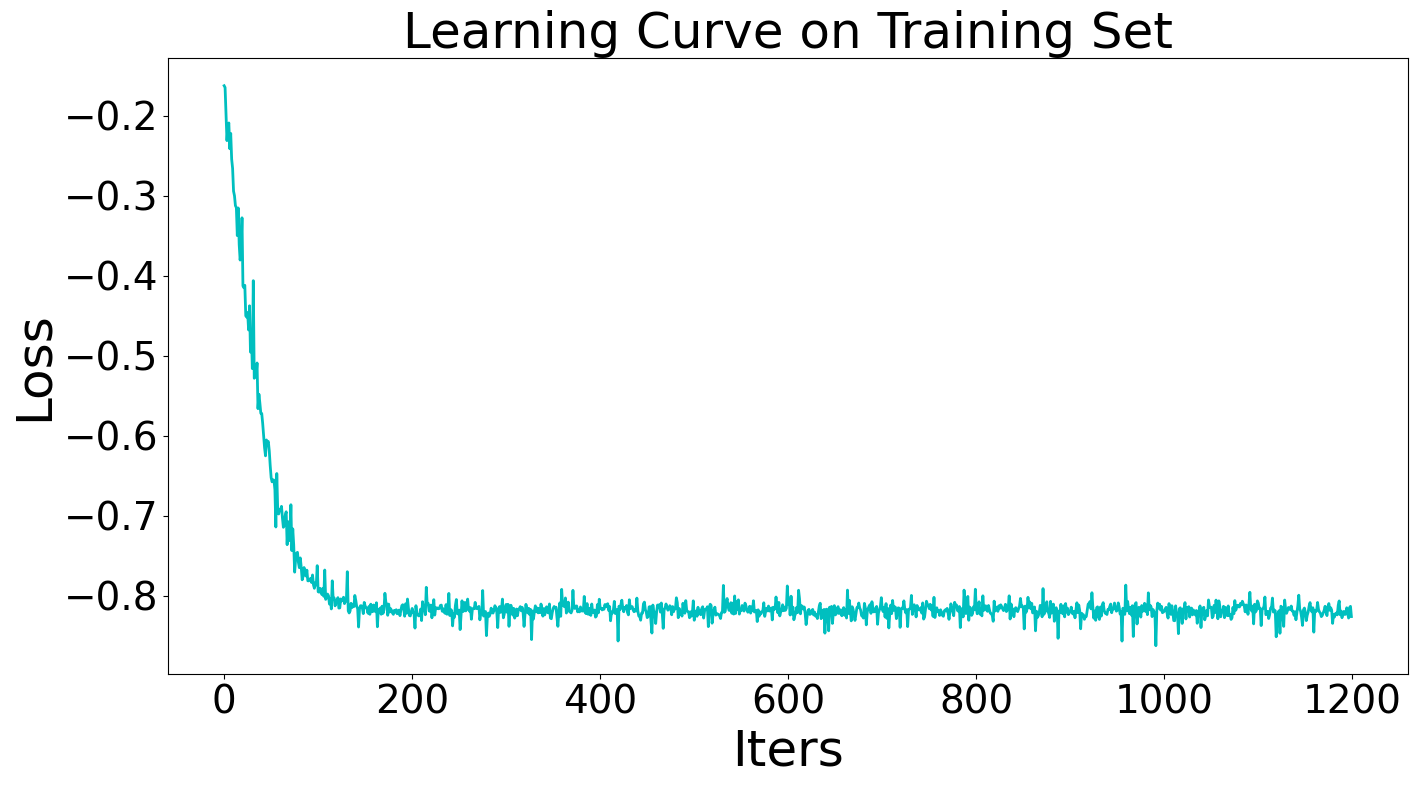

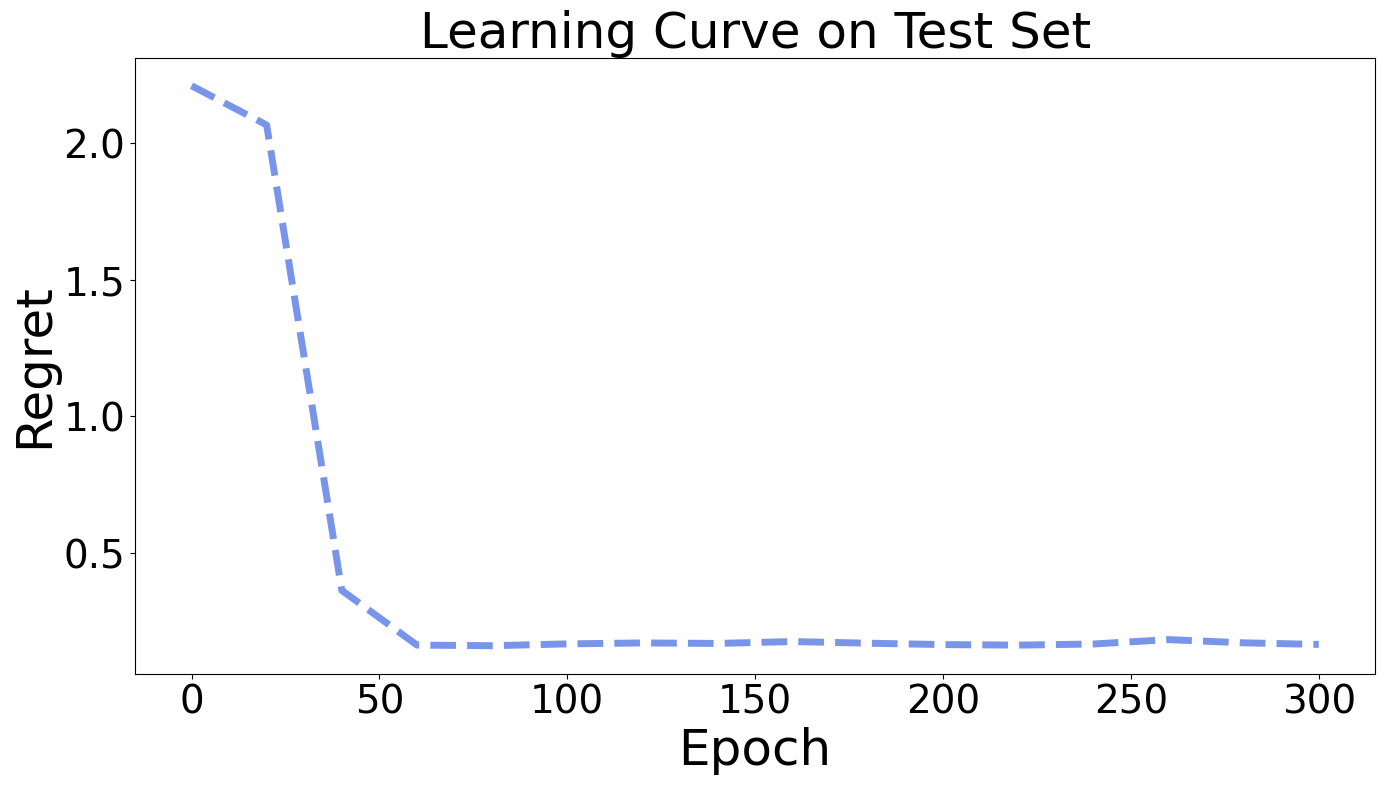

In [26]:
plot(loss_log, regret_log, num_epochs, log_step)

### PFYL 

In [27]:
# init model
reg = LinearRegression()

In [28]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [29]:
lr = 1e-2
num_epochs = 300
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  24.5000, Regret: 209.2721%
Epoch  20, Loss:  15.6667, Regret: 19.9786%
Epoch  40, Loss:  11.9444, Regret: 13.0345%
Epoch  60, Loss:  10.4444, Regret: 11.2156%
Epoch  80, Loss:   8.8889, Regret: 10.4054%
Epoch 100, Loss:   8.4444, Regret:  9.9755%
Epoch 120, Loss:   8.1667, Regret: 10.0757%
Epoch 140, Loss:   9.7222, Regret:  9.8044%
Epoch 160, Loss:   9.5000, Regret:  9.6578%
Epoch 180, Loss:   7.1111, Regret:  9.7164%
Epoch 200, Loss:  14.9444, Regret:  9.7228%
Epoch 220, Loss:   8.1111, Regret:  9.4795%
Epoch 240, Loss:  11.9444, Regret:  9.6796%
Epoch 260, Loss:   8.5000, Regret:  9.4806%
Epoch 280, Loss:   7.3889, Regret:  9.4255%
Elapsed Time: 740.30 Sec


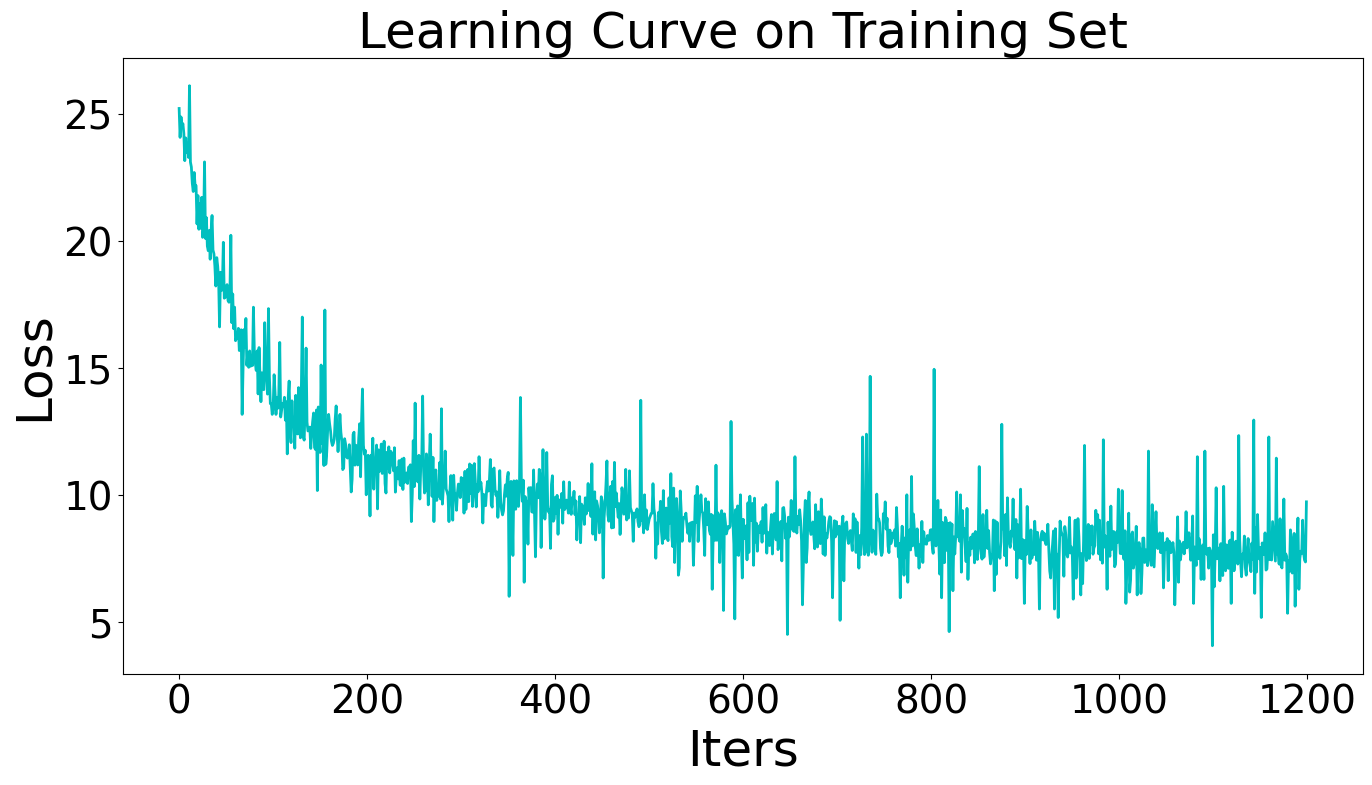

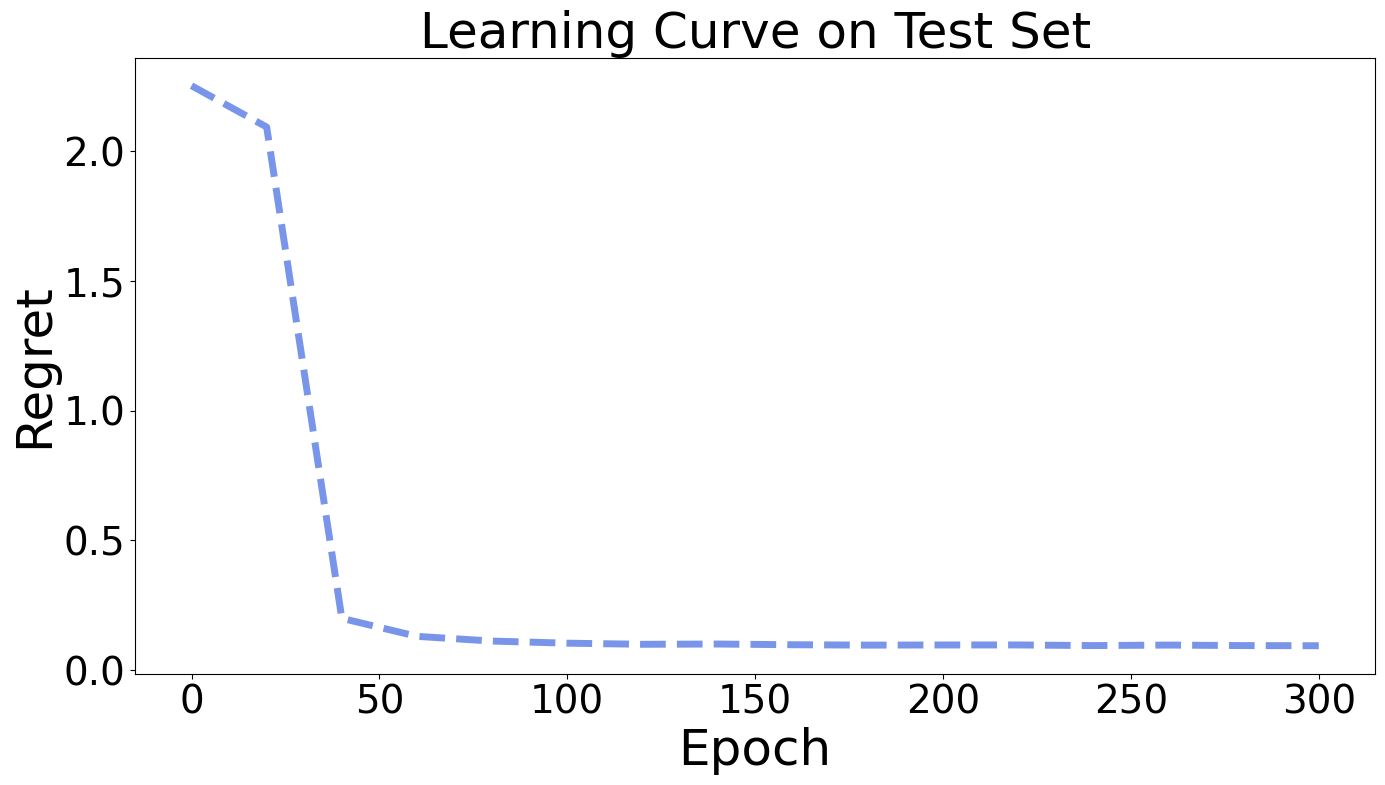

In [30]:
plot(loss_log, regret_log, num_epochs, log_step)